In [49]:
import numpy as np
import pandas as pd

from typing import Tuple

def extract_time(df: pd.DataFrame) -> np.ndarray:
    t = df['t'].to_numpy() * 1e-9
    return t

def sync_timeseries(
    ref_time: np.ndarray,
    ref_data: np.ndarray,
    data_time: np.ndarray,
    data: np.ndarray,
    fix_time: bool,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    idx = np.searchsorted(ref_time, data_time, side="right") - 1

    valid = idx >= 0

    t_sync = data_time[valid]
    ref_sync = ref_data[idx[valid]]
    data_sync = data[valid]

    if fix_time:
        t_sync -= t_sync[0]

    return t_sync, ref_sync, data_sync

In [50]:
from load_parquet import load_topic_dataframes

path = '../data/cc_two_levels_rosbag.parquet'
topics_file = 'topics_lists/topics_cc.txt'

ms2kmh = 3.6

In [51]:
dataframes = load_topic_dataframes(path, topics_file)
dataframes.keys()

dict_keys(['carla__hero__vehicle_control_cmd', 'carla__hero__v_ref', 'carla__hero__y_vector', 'carla__hero__velocity', 'carla__hero__imu'])

In [52]:
control = dataframes['carla__hero__vehicle_control_cmd']
control.head(1)

,t,throttle,steer,brake,hand_brake,reverse,gear,manual_gear
0,1766515200015699744,0.0,-0.0,1.0,False,False,0.0,False


In [53]:
v_ref = dataframes['carla__hero__v_ref']
v_ref.head(1)

,t,data
0,1766515202106322859,0.0


In [54]:
y_vector = dataframes['carla__hero__y_vector']
y_vector.head(1)

,t,x,y,z
0,1766515208458008988,-16.666667,0.0,0.0


In [55]:
velocity = dataframes['carla__hero__velocity']
velocity.head(1)

,t,data
0,1766515202105964427,0.0


In [56]:
imu = dataframes['carla__hero__imu']
imu.head(1)

,t,ax,ay,az,gx,gy,gz
0,1766515202128757294,-1.172908e-33,-2.124281e-37,9.81,-0.0,0.0,-0.0


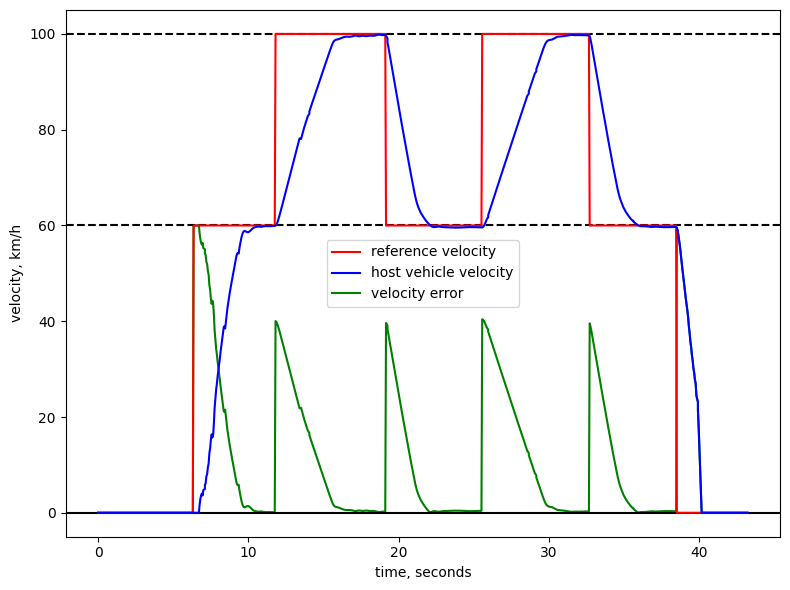

In [58]:
import matplotlib.pyplot as plt

v_ref_time = extract_time(v_ref)
v_ref_data = v_ref['data'].to_numpy() * ms2kmh

v_time = extract_time(velocity)
v_data = velocity['data'].to_numpy() * ms2kmh

t, v_ref_sync, v_sync = sync_timeseries(v_ref_time, v_ref_data, v_time, v_data, fix_time=True)

plt.figure(figsize=(8, 6))

plt.plot(t, v_ref_sync, label='reference velocity', color='r')
plt.plot(t, v_sync, label='host vehicle velocity', color='b')
plt.plot(t, np.abs(v_sync - v_ref_sync), label='velocity error', color='g', zorder=0)

plt.axhline(60, linestyle='--', zorder=0, color='black')
# plt.axhline(80, linestyle='--', zorder=0, color='black')
plt.axhline(100, linestyle='--', zorder=0, color='black')
plt.axhline(0, linestyle='-', zorder=0, color='black')

plt.legend()
plt.ylabel('velocity, km/h')
plt.xlabel('time, seconds')
plt.tight_layout()

plt.savefig('../data/cc_two_levels.png', dpi=600)